In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gprofiler import GProfiler

In [2]:
# Initialize gProfiler
gp = GProfiler(return_dataframe=True)
organism_id = 'mmusculus'

In [3]:
#Load the data with all DE results already computed
adata = sc.read_h5ad('condition_DE_analysis.h5ad')
#control vs infected
am_cells = sc.read_h5ad('am_cells_DE.h5ad') 
im_cells = sc.read_h5ad('im_cells_DE.h5ad') 

#MOST IMPORTANT: overall + contact vs bystander keys for both cell types!!
infected_cells = sc.read_h5ad('infected_cells_DE.h5ad')



In [4]:
print("Available keys:", [k for k in infected_cells.uns.keys() if 'rank' in k or 'vs' in k])

Available keys: ['am_bacterial_vs_bystander', 'bacterial_vs_bystander', 'im_bacterial_vs_bystander', 'ranked_genes']


In [5]:
# Extract top genes from each DE comparison
def get_top_genes(adata_obj, key, group, n_genes=20):
    """Extract top DE genes from scanpy results"""
    if key in adata_obj.uns:
        genes = adata_obj.uns[key]['names'][group][:n_genes].tolist()
        return [g for g in genes if pd.notna(g)]
    else:
        print(f"Key {key} not found")
        return []



def search_pathways(df, search_terms):
    """Search pathway results for specific terms"""
    if df.empty:
        return pd.DataFrame()
    mask = df['name'].str.contains('|'.join(search_terms), case=False, na=False)
    return df[mask][['name', 'p_value', 'source', 'intersection_size']]
            

stat6_terms = ['STAT6','DNA-binding transcription factor activity', 'IL-4', 'IL-13', 'Th2', 'alternative activation']
immune_terms = ['immune', 'antimicrobial', 'bacterial', 'pathogen', 'defense']
interferon_terms = ['interferon', 'antiviral', 'IFN']

### First we look for the pathways of the overall data to ensure our findings are biologically sound thus far
#### This means getting the top most differentially expressed genes in the overall data - that is, the genes that most exemplify the difference between infected and control cells 
#### We expect these sets (overall, overall-AM-only, and overally-IM-only) of top genes to produces pathway signatures that are typical of macrophage response to bacteria

In [18]:
#all data, the comparison is simply infected_vs_control
overall_infection_genes = get_top_genes(adata, 'infected_vs_control', 'Infected', 20)
print(f"Overall infection genes (n={len(overall_infection_genes)}): {overall_infection_genes}")


# Run gProfiler pathway analysis on each gene set
overall_infection_pathway_results = {}
# 1. Overall infection response
print("=== Analyzing Overall infection response pathways ===")
overall_infection_pathways = gp.profile(
    organism=organism_id,
    query=overall_infection_genes,
    sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
    'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
    'KEGG',   # Canonical pathways, often includes infection and signaling
    'REAC',   # Reactome pathways (detailed human pathways)
    'WP',     # WikiPathways (community curated, potentially specific)
    'TF'],
    user_threshold=0.05
)
print("STAT6-related pathways in Overall data:")
stat6_results = search_pathways(overall_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in Overall data:")
immune_results = search_pathways(overall_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      
# Compare to general infection pathways
print("\nInterferon pathways in Overall data:")
ifn_results = search_pathways(overall_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

Overall infection genes (n=20): ['Gbp2', 'Gbp7', 'Stat1', 'Nampt', 'Wfdc17', 'Gbp5', 'Parp14', 'Ctsc', 'AW112010', 'Ms4a6d', 'Lilrb4a', 'Ifih1', 'Cfb', 'Ifi47', 'AY036118', 'Rnf213', 'Tgfbi', 'Fbxl5', 'Oasl2', 'Slfn2']
=== Analyzing Overall infection response pathways ===
STAT6-related pathways in Overall data:
0 found: None found

Immune/antimicrobial pathways in Overall data:
15 found:                            name       p_value source  intersection_size
0              defense response  6.009491e-09  GO:BP                 12
1        innate immune response  1.604638e-08  GO:BP                 10
2               immune response  1.842729e-08  GO:BP                 12
3  defense response to symbiont  3.362385e-08  GO:BP                 10
4         immune system process  3.726257e-08  GO:BP                 13

Interferon pathways in Overall data:
7 found:                                        name   p_value source  \
12  cellular response to type II interferon  0.000003  GO:BP   
14

In [19]:
#all AM cell data, comparison is infected vs control
am_overall_infection_genes = get_top_genes(am_cells, 'am_infected_vs_control', 'Infected', 20)
print(f"AM Overall infection genes (n={len(am_overall_infection_genes)}): {am_overall_infection_genes}")

# Run gProfiler pathway analysis on each gene set
am_overall_infection_pathway_results = {}
# 1. Overall infection response
print("=== Analyzing AM-Overall infection response pathways ===")
am_overall_infection_pathways = gp.profile(
    organism=organism_id,
    query=am_overall_infection_genes,
    sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
    'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
    'KEGG',   # Canonical pathways, often includes infection and signaling
    'REAC',   # Reactome pathways (detailed human pathways)
    'WP',     # WikiPathways (community curated, potentially specific)
    'TF'],
    user_threshold=0.05
)
print("STAT6-related pathways in AM-Overall data:")
stat6_results = search_pathways(am_overall_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in AM-Overall data:")
immune_results = search_pathways(am_overall_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      
# Compare to general infection pathways
print("\nInterferon pathways in AM-Overall data:")
ifn_results = search_pathways(am_overall_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

AM Overall infection genes (n=20): ['mt-Nd4l', 'Plek', 'AY036118', 'Macf1', 'Ptprc', 'Wfdc17', 'Fbxl5', 'Gm21092', 'mt-Nd6', 'March1', 'Vps13c', 'mt-Nd5', 'Ifih1', 'Gm10076', 'Parp14', 'Usp9x', 'AI607873', 'Gbp2', 'Irf1', 'Ifi204']
=== Analyzing AM-Overall infection response pathways ===
STAT6-related pathways in AM-Overall data:
0 found: None found

Immune/antimicrobial pathways in AM-Overall data:
9 found:                                     name   p_value source  intersection_size
9     defense response to other organism  0.003488  GO:BP                  7
10  regulation of innate immune response  0.003913  GO:BP                  5
18         regulation of immune response  0.010117  GO:BP                  6
22         activation of immune response  0.012051  GO:BP                  5
23                innate immune response  0.012819  GO:BP                  6

Interferon pathways in AM-Overall data:
4 found:                                        name   p_value source  \
11     cellu

In [20]:
#all IM cell data, comparison is infected vs control
im_overall_infection_genes = get_top_genes(im_cells, 'im_infected_vs_control', 'Infected', 20)
print(f"im Overall infection genes (n={len(im_overall_infection_genes)}): {im_overall_infection_genes}")

# Run gProfiler pathway analysis on each gene set
im_overall_infection_pathway_results = {}
# 1. Overall infection response
print("=== Analyzing IM-Overall infection response pathways ===")
im_overall_infection_pathways = gp.profile(
    organism=organism_id,
    query=im_overall_infection_genes,
    sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
    'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
    'KEGG',   # Canonical pathways, often includes infection and signaling
    'REAC',   # Reactome pathways (detailed human pathways)
    'WP',     # WikiPathways (community curated, potentially specific)
    'TF',
    'HP'],
    user_threshold=0.05
)
print("STAT6-related pathways in IM-Overall data:")
stat6_results = search_pathways(im_overall_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in IM-Overall data:")
immune_results = search_pathways(im_overall_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      
# Compare to general infection pathways
print("\nInterferon pathways in IM-Overall data:")
ifn_results = search_pathways(im_overall_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

im Overall infection genes (n=20): ['Stat1', 'Gbp2', 'Oasl2', 'Gbp7', 'Gbp5', 'Parp14', 'Ms4a6d', 'Ifi47', 'Rnf213', 'Tap1', 'Trim30a', 'Isg15', 'Ifi204', 'Nampt', 'Slfn1', 'Slfn2', 'Cd300lf', 'Pydc4', 'Gbp3', 'Mndal']
=== Analyzing IM-Overall infection response pathways ===
STAT6-related pathways in IM-Overall data:
0 found: None found

Immune/antimicrobial pathways in IM-Overall data:
22 found:                                  name       p_value source  intersection_size
0              innate immune response  7.263669e-15  GO:BP                 14
1        defense response to symbiont  2.072489e-14  GO:BP                 14
3                     immune response  2.711022e-14  GO:BP                 16
4               immune system process  6.476767e-14  GO:BP                 17
5  defense response to other organism  2.591132e-13  GO:BP                 14

Interferon pathways in IM-Overall data:
6 found:                                        name       p_value source  \
12     cellula

### Now, the top gene sets for where we first ACTUALLY may find evidence of the STAT6 pathway that the paper characterized as part of the M(KP)
#### Note: they identified the M(Kp) state as a characteristic of only the IMs and not they AMs,
#### as their hypothesis of the KP-induced polarization state was based on IM being deemed permissive in their macrophage depletion and functional infection assay or in vivo depletion-infection model

In [21]:
#M(Kp) signature - bacterial+ vs bystander booth cell types
infection_genes = get_top_genes(infected_cells, 'bacterial_vs_bystander', 'KP+', 20)
print(f"Bacterial vs bystander signature genes (n={len(infection_genes)}): {infection_genes}")

# Run gProfiler pathway analysis on each gene set
infection_pathway_results = {}
# Infection response in both AM and IM
print("=== Analyzing Infection response pathways ===")
infection_pathways = gp.profile(
    organism=organism_id,
    query=infection_genes,
    sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
    'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
    'KEGG',   # Canonical pathways, often includes infection and signaling
    'REAC',   # Reactome pathways (detailed human pathways)
    'WP',     # WikiPathways (community curated, potentially specific)
    'TF',
    'HP'],
    user_threshold=0.05
)
print("STAT6-related pathways in Infection data:")
stat6_results = search_pathways(infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in Infection data:")
immune_results = search_pathways(infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      
# Compare to general infection pathways
print("\nInterferon pathways in Infection data:")
ifn_results = search_pathways(infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

Bacterial vs bystander signature genes (n=20): ['Fth1', 'Gm10076', 'Lgals3', 'Cxcl2', 'Cxcl3', 'Txn1', 'Cstb', 'Capg', 'AA467197', 'Ftl1', 'Il1a', 'Fabp5', 'S100a9', 'Prdx1', 'Slpi', 'S100a8', 'Atp6v1g1', 'Cd63', 'Gabarap', 'Il1rn']
=== Analyzing Infection response pathways ===
STAT6-related pathways in Infection data:
0 found: None found

Immune/antimicrobial pathways in Infection data:
10 found:                                         name   p_value source  \
12  response to molecule of bacterial origin  0.000424  GO:BP   
18                           immune response  0.001625  GO:BP   
19                      Innate Immune System  0.001715   REAC   
20                             Immune System  0.001758   REAC   
26            antimicrobial humoral response  0.002861  GO:BP   

    intersection_size  
12                  6  
18                  9  
19                  9  
20                 11  
26                  4  

Interferon pathways in Infection data:
0 found: None found


In [22]:
# M(Kp) signature - bacterial+ vs bystander both cell types
am_infection_genes = get_top_genes(infected_cells, 'am_bacterial_vs_bystander', 'KP+', 20)
print(f"AM bacterial vs bystander signature genes (n={len(am_infection_genes)}): {am_infection_genes}")

# Run gProfiler pathway analysis on each gene set
am_infection_pathway_results = {}
# Infection response in both AM and IM
print("=== Analyzing AM-infection response pathways ===")
am_infection_pathways = gp.profile(
    organism=organism_id,
    query=am_infection_genes,
    sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
    'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
    'KEGG',   # Canonical pathways, often includes infection and signaling
    'REAC',   # Reactome pathways (detailed human pathways)
    'WP',     # WikiPathways (community curated, potentially specific)
    'TF',
    'HP'],
    user_threshold=0.05
)
print("STAT6-related pathways in AM-infection data:")
stat6_results = search_pathways(am_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in AM-infection data:")
immune_results = search_pathways(am_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      
# Compare to general infection pathways
print("\nInterferon pathways in AM-infection data:")
ifn_results = search_pathways(am_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

AM bacterial vs bystander signature genes (n=20): ['Gm10076', 'Fcer1g', 'Cd52', 'Il1b', 'Prdx5', 'Cd74', 'H2-Q7', 'H2-D1', 'Atox1', 'Samhd1', 'Psme2', 'AA467197', 'Srgn', 'H2-K1', 'Cxcl3', 'Bcl2a1d', 'Stat1', 'Psmb8', 'Cyba', 'Zbp1']
=== Analyzing AM-infection response pathways ===
STAT6-related pathways in AM-infection data:
0 found: None found

Immune/antimicrobial pathways in AM-infection data:
27 found:                                               name       p_value source  \
1                    regulation of immune response  1.487989e-07  GO:BP   
6                                  immune response  6.383398e-07  GO:BP   
7           positive regulation of immune response  7.365146e-07  GO:BP   
8  positive regulation of adaptive immune response  1.135122e-06  GO:BP   
9              regulation of immune system process  1.296600e-06  GO:BP   

   intersection_size  
1                 10  
6                 12  
7                  9  
8                  6  
9                 11  


In [23]:
# M(Kp) signature - bacterial+ vs bystander booth cell types
im_infection_genes = get_top_genes(infected_cells, 'im_bacterial_vs_bystander', 'KP+', 20)
print(f"IM bacterial vs bystander signature genes (n={len(im_infection_genes)}): {im_infection_genes}")

# Run gProfiler pathway analysis on each gene set
im_infection_pathway_results = {}
# Infection response in both AM and IM
print("=== Analyzing AM-infection response pathways ===")
im_infection_pathways = gp.profile(
    organism=organism_id,
    query=im_infection_genes,
    sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
    'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
    'KEGG',   # Canonical pathways, often includes infection and signaling
    'REAC',   # Reactome pathways (detailed human pathways)
    'WP',     # WikiPathways (community curated, potentially specific)
    'TF',
    'HP'],
    user_threshold=0.05
)
print("STAT6-related pathways in AM-infection data:")
stat6_results = search_pathways(im_infection_pathways, stat6_terms)
print(f"{len(stat6_results)} found:", stat6_results if not stat6_results.empty else "None found")
print("\nImmune/antimicrobial pathways in AM-infection data:")
immune_results = search_pathways(im_infection_pathways, immune_terms)
print(f"{len(immune_results)} found:", immune_results.head() if not immune_results.empty else "None found")      
# Compare to general infection pathways
print("\nInterferon pathways in AM-infection data:")
ifn_results = search_pathways(im_infection_pathways, interferon_terms)
print(f"{len(ifn_results)} found:", ifn_results.head() if not ifn_results.empty else "None found")

IM bacterial vs bystander signature genes (n=20): ['Ctsd', 'Chil3', 'Fth1', 'Cd9', 'Vim', 'Fabp5', 'Ftl1', 'Lgals3', 'Wfdc21', 'F7', 'Atp6v0d2', 'Prdx1', 'Actn1', 'Slpi', 'Txn1', 'Plet1', 'S100a10', 'Pld3', 'Cd44', 'Anxa2']
=== Analyzing AM-infection response pathways ===
STAT6-related pathways in AM-infection data:
0 found: None found

Immune/antimicrobial pathways in AM-infection data:
2 found:                     name   p_value source  intersection_size
5  immune system process  0.013476  GO:BP                 10
8   Innate Immune System  0.018008   REAC                  8

Interferon pathways in AM-infection data:
0 found: None found


### None of our infected tissue signature gene sets relate to STAT6 pathways and cannot directly support the paper's finding yet,
### This was to be expected as the M(KP) is not the classical bacteria lreaction state, and any signal of it is likely diluted. Currently, our cells are not at a standardized time and a transient state (the STAT6-showing M(KP) polarization state), even if occurring, would be diluted in the current sets we have looked at

    What has been found so far:
  - Classical antimicrobial macrophage response
  - Neutrophil recruitment pathways
  - Iron sequestration (nutritional immunity)
  - This is good biology even if different from their STAT6 story
    
  The findings so far are still valuable:
  - Confirm bacterial+ cells are biologically distinct ✓
  - Show clear antimicrobial response ✓
  - Validate infection model works ✓
  - Identify key inflammatory pathways ✓



### Its possible that signatures for the STAT6-related pathways may exist in a cluster of our groups and are still too diluted in our current sets. Look at the clusters (this time only of infected tissue cells) below

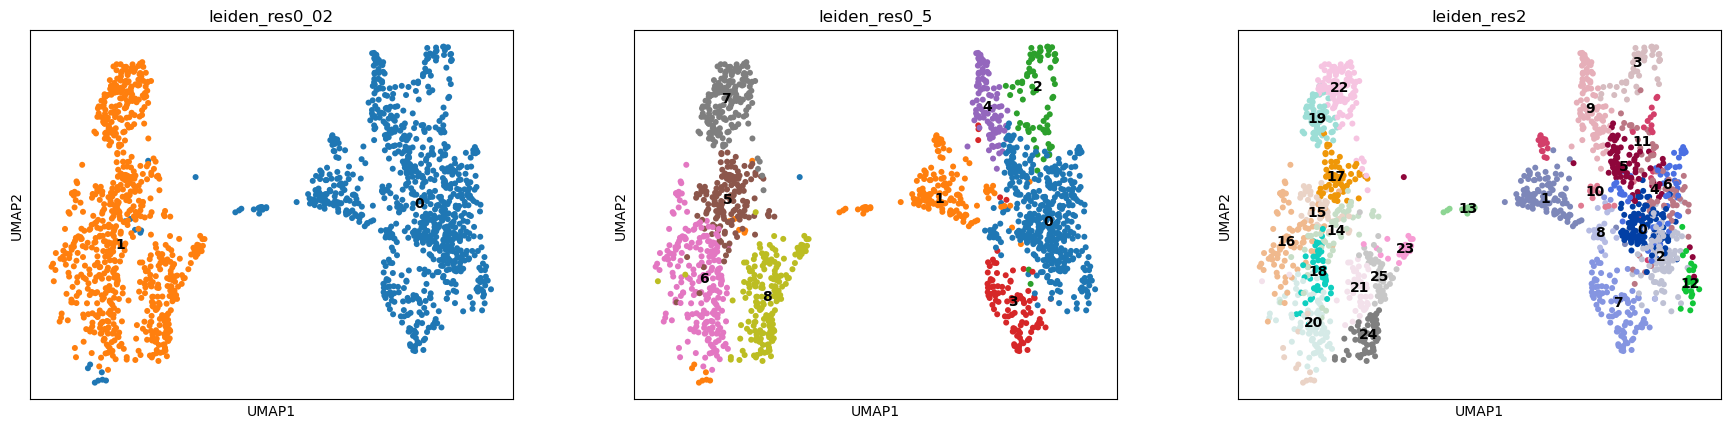

In [35]:
sc.tl.leiden(infected_cells, flavor="igraph", key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(infected_cells, flavor="igraph", key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(infected_cells, flavor="igraph", key_added="leiden_res2", resolution=2)

sc.pl.umap(
    infected_cells,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

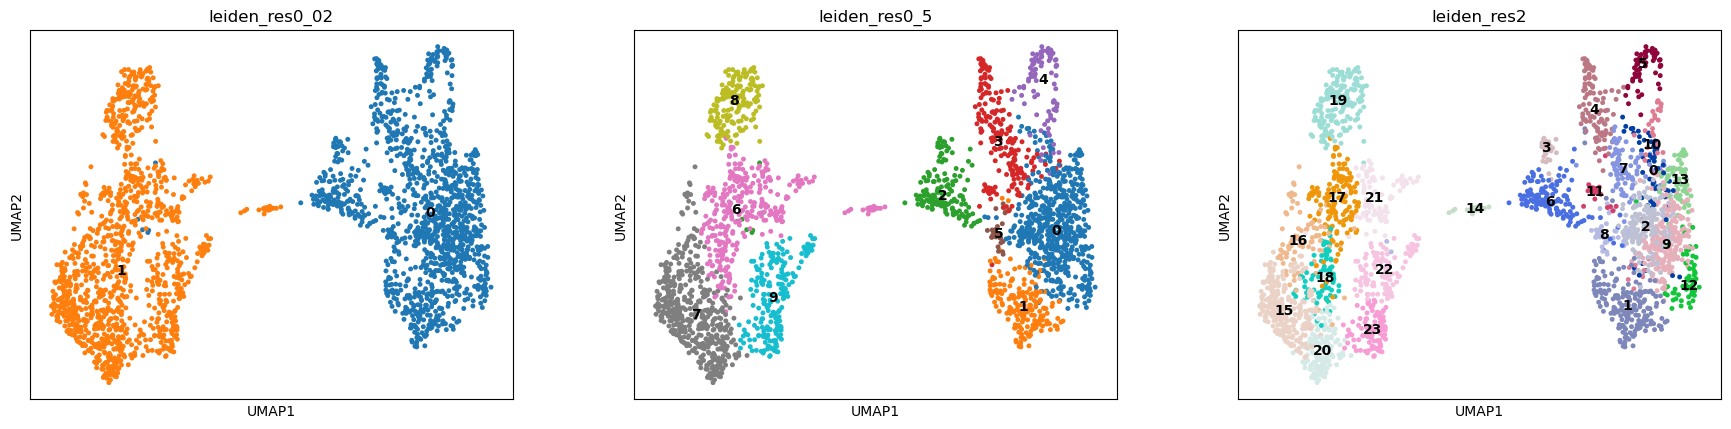

In [36]:
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", key_added="leiden_res2", resolution=2)

sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)